# Saudi League Analysis
# Part 3: Modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore");
pd.set_option('display.max_rows', None);
sns.set_context("talk");
%matplotlib inline

# ================================================

from yellowbrick.regressor import ResidualsPlot
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

# Content:
## 1- Load Data
## 2- Features Selection
- Correlation Based
- Recursive Feature Elimination

## 3- Models Selection
- Check Different Models
- Hyper-parameters Tuning

## 4- Model Evaluation

***
# ***Load Data***
***

In [4]:
data = pd.read_csv('cleaned.csv')
data18 = pd.read_csv('cleaned18')
data.head()

,year,Rk,Squad,MP,W,D,L,GF,GA,GDiff,...,Ast,G+A,onG,CS,CS%,PKA,PKm,PKsv,Saves,SoTA
0,2019,1,Al-Hilal,30,22,6,2,74,26,48,...,48,8,814,10,33,3,1,1,74,97
1,2018,1,Al-Nassr,30,22,4,4,69,27,42,...,50,6,759,13,43,5,1,0,69,91
2,2018,2,Al-Hilal,30,21,6,3,66,33,33,...,40,9,723,9,30,6,0,0,55,82
3,2021,1,Al-Hilal,30,20,7,3,63,28,35,...,45,8,691,12,40,7,0,0,65,86
4,2016,1,Al-Hilal,26,21,3,2,63,16,47,...,40,15,691,13,50,0,0,2,0,0


In [5]:
data18.head()

,Squad,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,...,W,D,L,CS,CS%,PKatt.2,PKA,PKsv,PKm,P-Save%
0,Al-Ahli,35,27.5,55.2,30,330,2700,30.0,37,21,...,6,14,10,5,16.7,4,4,0,0,0.0
1,Al-Faisaly,31,28.7,51.0,30,330,2700,30.0,28,18,...,7,12,11,10,33.3,6,5,1,0,16.7
2,Al-Fateh,39,28.3,52.5,30,330,2700,30.0,45,25,...,9,8,13,9,30.0,10,5,5,0,50.0
3,Al-Hilal,31,29.2,64.3,30,330,2700,30.0,63,45,...,20,7,3,12,40.0,7,7,0,0,0.0
4,Al-Ittihad,29,28.7,52.4,30,330,2700,30.0,60,41,...,20,5,5,12,40.0,3,2,1,0,33.3


***
# ***Features Selection***
***

In [8]:
# Function to Remove Corrlated Featuers
def cor_featuers(data, threshold):
    cor_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)) :
        for j in range(i):
            if abs(corrmat.iloc[i,j]) > threshold:
                colname = corrmat.columns[i]
                cor_col.add(colname)
    
    return cor_col

### 1- Features Selection

#### A- Features Selection Based on Correlation

In [9]:
# Filter Features based on a threshold
th = 0.75

print('Number of removed featurs:' ,len(cor_featuers(data, th)))
print('Featuers to be removed ',(cor_featuers(data,th)))

Number of removed featurs: 31
Featuers to be removed  {'Pts/MP-A', 'L-A', 'GA', 'MP-A', 'Pts-A', 'W-H', 'L', 'GD-H', 'W-A', 'D-A', 'GF-A', 'GA-A', 'D-H', 'GD-A', 'Pts-H', 'CS%', 'onG', 'MP', 'GDiff', 'Pts/MP-H', 'W', 'Saves', 'GF-H', 'SoTA', 'Pts/Mp', 'Pts', 'Min', 'L-H', 'GF', 'Ast', 'GA-H'}


In [10]:
# Filter Features based on a threshold
th = 0.75

print('Number of removed featurs:' ,len(cor_featuers(data18, th)))
print('Featuers to be removed ',(cor_featuers(data18,th)))

Number of removed featurs: 31
Featuers to be removed  {'SoT/90', 'PKatt', 'GA', 'Ast', 'PK.1', 'L', 'PPM', 'G+A', 'G+A-PK', 'G/Sh', 'G-PK', 'P-Save%', 'Sh/90', '+/-90', 'Ast-90', 'onG', 'Gls-90', 'year', 'W', 'Saves', 'G-PK-90', 'PKA', '+/-', 'G/SoT', 'GA90', 'onGA', 'unSub', 'SoT', 'PKatt.1', 'SoT%', 'CS%'}


In [11]:
# Add to the removed features Attendance since it is unknown until the end of the season
#                             and year because it has no known effects on teams points

f_to_drop = ['MP', 'GF', 'GDiff', 'L', 'GA', 'Min', 'W', 'Pts','Pk', 'D', 'Rk','Attendance', 'year']
X = data.drop( f_to_drop , axis=1)
y = data.Pts

In [12]:
# Remained features:
print('Remained features', X.columns.values)

Remained features ['Squad' 'Pts/Mp' 'W-H' 'D-H' 'L-H' 'GF-H' 'GA-H' 'GD-H' 'Pts-H'
 'Pts/MP-H' 'MP-A' 'W-A' 'D-A' 'L-A' 'GF-A' 'GA-A' 'GD-A' 'Pts-A'
 'Pts/MP-A' 'Age' 'n_FW' 'n_MF' 'n_DF' 'n_GK' 'n_S' 'n_nS' 'Ast' 'G+A'
 'onG' 'CS' 'CS%' 'PKA' 'PKm' 'PKsv' 'Saves' 'SoTA']


In [13]:
# Standardize features and encode Squad column
sc = StandardScaler()
X_sc = sc.fit_transform(X.drop('Squad', axis=1))
X_sc = pd.DataFrame(X_sc, columns= X.columns.drop('Squad'))
X_sc = pd.concat([pd.get_dummies(X.Squad).drop('Al-Taawoun', axis=1), X_sc], axis=1)
X_sc.head()

,Al-Ahli,Al-Faisaly,Al-Fateh,Al-Hilal,Al-Ittihad,Al-Nassr,Al-Raed,Al-Shabab,Pts/Mp,W-H,...,Ast,G+A,onG,CS,CS%,PKA,PKm,PKsv,Saves,SoTA
0,0,0,0,1,0,0,0,0,1.521278,2.434686,...,2.044004,0.507681,2.423707,0.848769,0.613444,-0.639112,0.315840,0.262111,0.777614,0.675624
1,0,0,0,0,0,1,0,0,1.521278,2.034464,...,2.243149,-0.077168,1.996470,1.959886,1.657603,0.205219,0.315840,-0.786334,0.659296,0.573321
2,0,0,0,1,0,0,0,0,1.521278,0.833797,...,1.247423,0.800106,1.716824,0.478397,0.300196,0.627385,-0.672876,-0.786334,0.328005,0.419867
3,0,0,0,1,0,0,0,0,1.521278,1.634241,...,1.745286,0.507681,1.468250,1.589514,1.344355,1.049551,-0.672876,-0.786334,0.564641,0.488069
4,0,0,0,1,0,0,0,0,1.521278,0.833797,...,1.247423,2.554653,1.468250,1.959886,2.388515,-1.905609,-0.672876,1.310556,-0.973497,-0.978269


#### 2- Models Selection

In [14]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_sc,y , test_size=0.2, random_state=400)
X_train.shape, X_test.shape

((57, 43), (15, 43))

#### A- Check Different Models

R2:			 0.9460327425508283
rmse:			 3.151719107619417
mae:			 2.466666666666667

True values:		 [38 42 64 39 52 55 36 56 32 35 30 69 24 33 24]
Predicted values:	 [39 44 63 37 51 52 37 54 34 37 31 64 32 34 29]


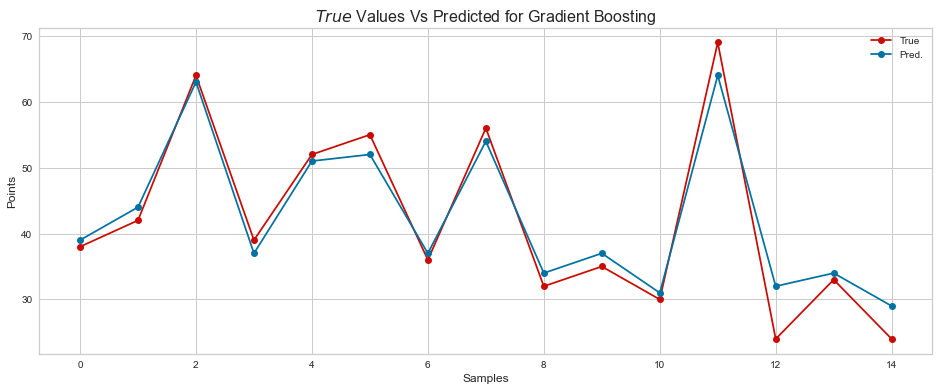

In [15]:
# Root mean squared error
def rms(y_test,y_pred):
    return np.sqrt(mean_squared_error(y_test,y_pred))

# Gradient Boosting Regressor
gr = GradientBoostingRegressor(criterion='mse', learning_rate=0.01,
                          max_features='sqrt', n_estimators=591,
                          random_state=1720)
gr.fit(X_train,y_train)
y_pred = np.round(gr.predict(X_test)).astype('int32')
print('R2:\t\t\t', r2_score(y_test,y_pred))
print('rmse:\t\t\t', rms(y_test,y_pred))
print('mae:\t\t\t', mean_absolute_error(y_test,y_pred))
print()
print('True values:\t\t',np.array(y_test).reshape(1,-1)[0])
print('Predicted values:\t',y_pred)
plt.figure(figsize=(16,6))
plt.plot(np.array(y_test).reshape(1,-1)[0], 'ro-', label='True');
plt.plot(y_pred, 'bo-', label='Pred.');
plt.legend();
plt.grid();
plt.title('$True$ Values Vs Predicted for Gradient Boosting', fontsize=16)
plt.ylabel('Points', fontsize=12);
plt.xlabel('Samples', fontsize=12);
plt.grid();

R2:			 1.0
rmse:			 0.0
mae:			 0.0

True values:		 [38 42 64 39 52 55 36 56 32 35 30 69 24 33 24]
Predicted values:	 [38 42 64 39 52 55 36 56 32 35 30 69 24 33 24]


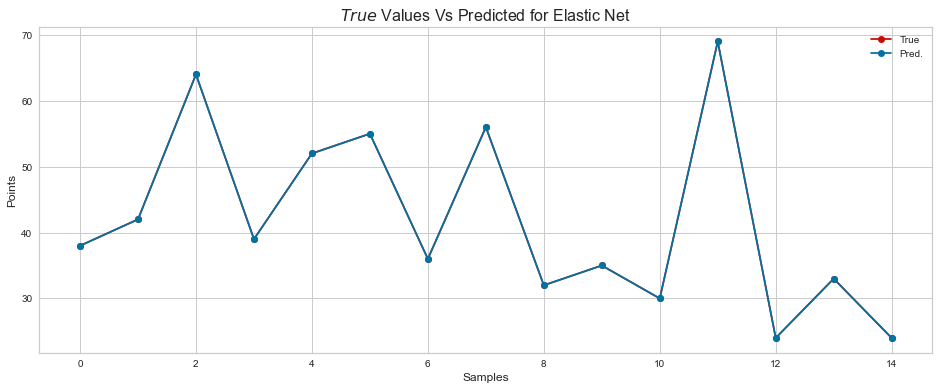

In [17]:
# Elastic Net Regressor
en = ElasticNet(alpha=0.01 ,l1_ratio=1,  normalize=True, random_state=0)
en.fit(X_train,y_train)
y_pred = np.round(en.predict(X_test)).astype('int32')
print('R2:\t\t\t', r2_score(y_test,y_pred))
print('rmse:\t\t\t', rms(y_test,y_pred))
print('mae:\t\t\t', mean_absolute_error(y_test,y_pred))
print()
print('True values:\t\t',np.array(y_test).reshape(1,-1)[0])
print('Predicted values:\t',y_pred)
plt.figure(figsize=(16,6))
plt.plot(np.array(y_test).reshape(1,-1)[0], 'ro-', label='True');
plt.plot(y_pred, 'bo-', label='Pred.');
plt.legend();
plt.grid();
plt.title('$True$ Values Vs Predicted for Elastic Net', fontsize=16)
plt.ylabel('Points', fontsize=12);
plt.xlabel('Samples', fontsize=12);
plt.grid();

R2:			 0.9971024291302458
rmse:			 0.7302967433402214
mae:			 0.5333333333333333

True values:		 [38 42 64 39 52 55 36 56 32 35 30 69 24 33 24]
Predicted values:	 [39 42 64 40 52 56 37 56 32 34 30 70 25 33 25]


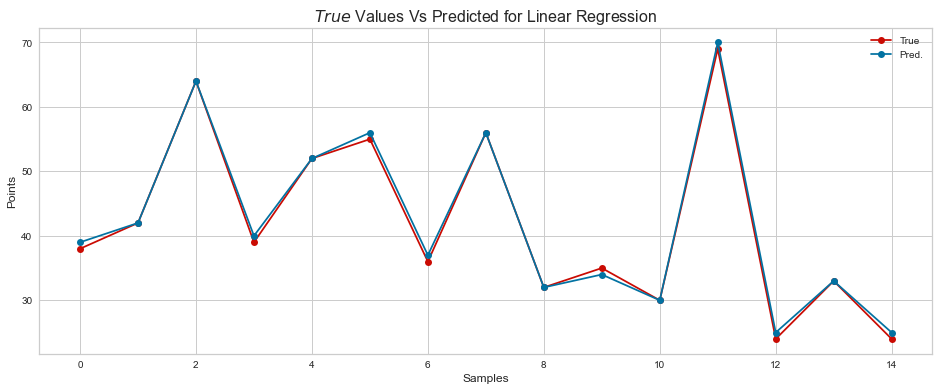

In [18]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = np.round(lr.predict(X_test)).astype('int32')
print('R2:\t\t\t', r2_score(y_test,y_pred))
print('rmse:\t\t\t', rms(y_test,y_pred))
print('mae:\t\t\t', mean_absolute_error(y_test,y_pred))
print()
print('True values:\t\t',np.array(y_test).reshape(1,-1)[0])
print('Predicted values:\t',y_pred)
plt.figure(figsize=(16,6))
plt.plot(np.array(y_test).reshape(1,-1)[0], 'ro-', label='True');
plt.plot(y_pred, 'bo-', label='Pred.');
plt.legend();
plt.grid();
plt.title('$True$ Values Vs Predicted for Linear Regression', fontsize=16)
plt.ylabel('Points', fontsize=12);
plt.xlabel('Samples', fontsize=12);
plt.grid();

#### B- Hyper-parameters Tuning For Elastic Net Model

In [19]:
# Calculate bic for regression
def calculate_bic(n, mse, num_params):
    bic = n * np.log(mse) + num_params * np.log(n)
    return bic

# Calculate adjusted R2 for regression
def adj_r2(r2, n, p):
    '''where n is number of samples and p is number of features'''
    return 1- ( (1-r2) * ((n-1) / (n-p-1)) )

In [20]:
parameters = {'alpha':[0, 0.01, 0.001],
             'l1_ratio':[0, 0.01, 0.001],
             'fit_intercept': [False, True],
             'max_iter': [96,97,98, 99, 100, 102, 103, 197],
             }
en = ElasticNet(random_state=1720)
reg = GridSearchCV(en, parameters,verbose=2, scoring=make_scorer(rms,greater_is_better=False), cv=5)
reg.fit(X_sc,y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96; total time=   0.1s
[CV] END alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96; total time=   0.0s
[CV] END alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96; total time=   0.0s
[CV] END alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96; total time=   0.0s
[CV] END alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96; total time=   0.1s
[CV] END alpha=0, fit_intercept=False, l1_ratio=0, max_iter=97; total time=   0.0s
[CV] END alpha=0, fit_intercept=False, l1_ratio=0, max_iter=97; total time=   0.0s
[CV] END alpha=0, fit_intercept=False, l1_ratio=0, max_iter=97; total time=   0.0s
[CV] END alpha=0, fit_intercept=False, l1_ratio=0, max_iter=97; total time=   0.0s
[CV] END alpha=0, fit_intercept=False, l1_ratio=0, max_iter=97; total time=   0.0s
[CV] END alpha=0, fit_intercept=False, l1_ratio=0, max_iter=98; total time=   0.0s
[CV] END alpha=0, fit_in

GridSearchCV(cv=5, estimator=ElasticNet(random_state=1720),
             param_grid={'alpha': [0, 0.01, 0.001],
                         'fit_intercept': [False, True],
                         'l1_ratio': [0, 0.01, 0.001],
                         'max_iter': [96, 97, 98, 99, 100, 102, 103, 197]},
             scoring=make_scorer(rms, greater_is_better=False), verbose=2)

In [22]:
print('Best estimator: ', reg.best_estimator_,'\n')
print('Best score: ', reg.best_score_ )

Best estimator:  ElasticNet(alpha=0.001, l1_ratio=0.01, max_iter=197, random_state=1720) 

Best score:  -0.5154350345587073


### 1- Features Selection

####  B- Recursive Feature Elimination

In [23]:
# Get the best number of features recursively
for i in range(1,X_train.shape[1] + 1):
    print('Number of Features: ',i)

    estimator = reg.best_estimator_
    selector = RFE(estimator, n_features_to_select=i)

    selector = selector.fit(X_train, y_train)
    X_train1 = selector.transform(X_train)
    X_test1 = selector.transform(X_test)
    
    estimator.fit(X_train1, y_train)
    y_pred = np.round(estimator.predict(X_test1)).astype('int32')
    
    n = X_train1.shape[0]
    p = X_train1.shape[1]
    r2 = r2_score(y_test,y_pred)
    print('R2:\t\t\t', np.round(r2 ,3))
    print('Adj. R2:\t\t', np.round(adj_r2(r2, n, p) ,3))
    print('rmse:\t\t\t', np.round(np.sqrt(mean_squared_error(y_test,y_pred)), 3))
    print('mae:\t\t\t', np.round(mean_absolute_error(y_test,y_pred),3))
    print('BIC: \t\t\t', np.round(calculate_bic(len(y_train), mean_squared_error(y_test,y_pred), i),3))
    print('============')

Number of Features:  1
R2:			 0.769
Adj. R2:		 0.764
rmse:			 6.527
mae:			 5.533
BIC: 			 217.899
Number of Features:  2
R2:			 0.976
Adj. R2:		 0.975
rmse:			 2.098
mae:			 1.867
BIC: 			 92.538
Number of Features:  3
R2:			 0.978
Adj. R2:		 0.977
rmse:			 2.017
mae:			 1.8
BIC: 			 92.09
Number of Features:  4
R2:			 0.99
Adj. R2:		 0.989
rmse:			 1.366
mae:			 1.2
BIC: 			 51.749
Number of Features:  5
R2:			 1.0
Adj. R2:		 1.0
rmse:			 0.0
mae:			 0.0
BIC: 			 -inf
Number of Features:  6
R2:			 1.0
Adj. R2:		 1.0
rmse:			 0.0
mae:			 0.0
BIC: 			 -inf
Number of Features:  7
R2:			 1.0
Adj. R2:		 1.0
rmse:			 0.0
mae:			 0.0
BIC: 			 -inf
Number of Features:  8
R2:			 1.0
Adj. R2:		 1.0
rmse:			 0.0
mae:			 0.0
BIC: 			 -inf
Number of Features:  9
R2:			 1.0
Adj. R2:		 1.0
rmse:			 0.0
mae:			 0.0
BIC: 			 -inf
Number of Features:  10
R2:			 1.0
Adj. R2:		 1.0
rmse:			 0.0
mae:			 0.0
BIC: 			 -inf
Number of Features:  11
R2:			 1.0
Adj. R2:		 1.0
rmse:			 0.0
mae:			 0.0
BIC: 			 

Selected features:
['W-H' 'L-H' 'GF-H' 'MP-A' 'W-A' 'L-A' 'onG'] 

Model metrics: 
R2:	 1.0
rmse:	 0.0
mae:	 0.0

True values:  		 [38 42 64 39 52 55 36 56 32 35 30 69 24 33 24]
Predicted values:  	 [38 42 64 39 52 55 36 56 32 35 30 69 24 33 24]


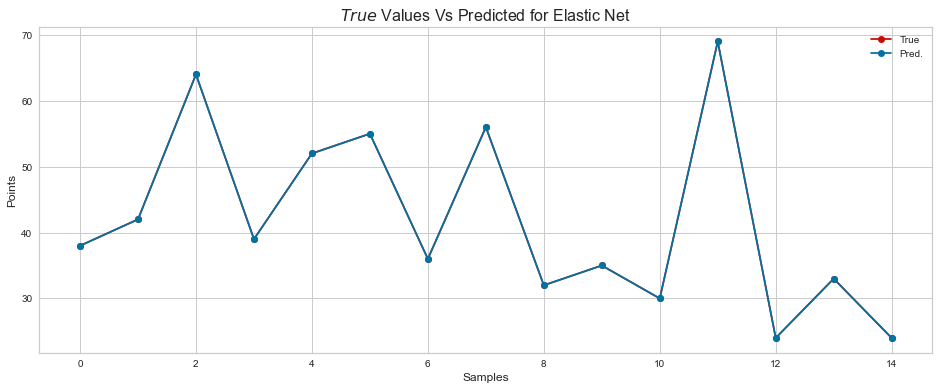

In [24]:
# Based on the model , 7 features are giving the best score
f = 7

estimator = reg.best_estimator_
selector = RFE(estimator, n_features_to_select=f)

selector = selector.fit(X_train, y_train)
X_train1 = selector.transform(X_train)
X_test1 = selector.transform(X_test)

print('Selected features:')
print(X_train.columns[selector.get_support()].values, '\n')

estimator.fit(X_train1, y_train)
y_pred = np.round(estimator.predict(X_test1)).astype('int32')

print('Model metrics: ')
print('=====================')
print('R2:\t', r2_score(y_test,y_pred))
print('rmse:\t', np.sqrt(mean_squared_error(y_test,y_pred)))
print('mae:\t', mean_absolute_error(y_test,y_pred))
print('=====================','\n')
print('True values: ','\t\t',y_test.values)
print('Predicted values: ','\t', y_pred)

plt.figure(figsize=(16,6))
plt.plot(np.array(y_test).reshape(1,-1)[0], 'ro-', label='True');
plt.plot(y_pred, 'bo-', label='Pred.');
plt.legend();
plt.grid();
plt.title('$True$ Values Vs Predicted for Elastic Net', fontsize=16)
plt.ylabel('Points', fontsize=12);
plt.xlabel('Samples', fontsize=12);
plt.grid();


In [30]:
teams_list = ['Al-Ahli','Al-Hilal','Al-Ittihad','Al-Nassr','Al-Shabab']
selected_f = X_train.columns[selector.get_support()].values
teams = X_train[selected_f]
teams.head()

,W-H,L-H,GF-H,MP-A,W-A,L-A,onG
28,1.234019,-0.868117,0.258371,1.0,-0.587334,1.258306,-0.380521
45,-1.167315,1.250676,-0.671765,1.0,-0.228961,0.463586,-0.326146
32,0.833797,-0.868117,1.653576,-1.0,-0.587334,0.066227,0.683687
54,-0.366871,-0.338418,-0.051674,-1.0,-0.945707,0.860946,-0.232930
55,-1.567538,0.191280,-1.291856,-1.0,-0.228961,0.066227,-1.514641


## 4- Model Evaluation

In [31]:
# Predict next season points
def pred(team, n_df, n_s):
    """ n_df: number of defenders
        n_s: number of Saudi layers """
    team_dict = {}
    # Get the encoded vlaues for each team
    for t in teams_list:
        v = np.array(teams[teams[t] == 1].reset_index(drop=True).loc[0]).reshape(1,-1)[0]
        team_dict[t] = v[:-2]
        
    team_dict['Al-Taawoun'] = np.array([0, 0, 0, 0, 0])
    team_dict['Al-Faisaly'] = np.array([0, 0, 0, 0, 0])
    team_dict['Al-Fateh'] = np.array([0, 0, 0, 0, 0])
    team_dict['Al-Raed'] = np.array([0, 0, 0, 0, 0])
    
    temp = sc.transform(np.array([22, 22, 22, n_df, 22, n_s, 22]).reshape(1,-1))[0]
    temp = temp[3:6]
    temp = np.delete(temp, 1, 0)
    
    x_t = np.concatenate((team_dict[team],temp ), axis=0).reshape(1,-1)
    y_pred =  estimator.predict(x_t)
    y_pred = np.round(y_pred).astype('int32')[0]
    
    print('Predicted Points Next Season for {} is:'.format(team), y_pred, 'points')
    print('===============================\n')
    
    print(u"\u00B1", 3.9, 'points for 68%')
    print('The Range of Predicted Points for {} is:'.format(team), round(y_pred - 3.9), 'and', round(y_pred + 3.9),
         'points')
    print('===============================\n')
    print(u"\u00B1", 7.8, 'points for 95%')
    print('The Range of Predicted Points for {} is:'.format(team), round(y_pred - 7.8), 'and', round(y_pred + 7.8),
         'points')

In [32]:
# ['Al-Hilal', 'Al-Nassr', 'Al-Ahli', 'Al-Taawoun', 'Al-Shabab','Al-Ittihad', 'Al-Faisaly', 'Al-Raed', 'Al-Fateh']

# pred(Team, no of DF players, no of Saudi players)
pred('Al-Shabab', 4, 25)

KeyError: 'Al-Ahli'

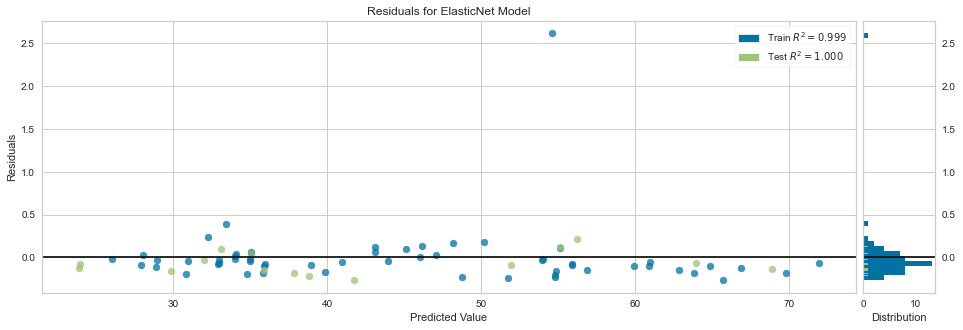

In [33]:
plt.figure(figsize=(16,5));
visualizer = ResidualsPlot(estimator)
visualizer.fit(X_train1, y_train);
visualizer.score(X_test1, y_test);
visualizer.show();